In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

# Load data
base_path = "/home/tvanhout/oxides_ML/models/test_training"
directory = "cn_test"
#directory = "gcn_test_5_sf_2"

df_training     = pd.read_csv(os.path.join(base_path, directory , "training.csv"))
df_train_set    = pd.read_csv(os.path.join(base_path, directory , "train_set.csv")) 
df_test_set     = pd.read_csv(os.path.join(base_path, directory , "test_set.csv"))
df_val_set      = pd.read_csv(os.path.join(base_path, directory , "validation_set.csv"))
df_uq           = pd.read_csv(os.path.join(base_path, directory , "uq.csv"))

df_test_set[["Abs_error_eV"]].mean()

Abs_error_eV    0.342426
dtype: float64

## Performance metrics

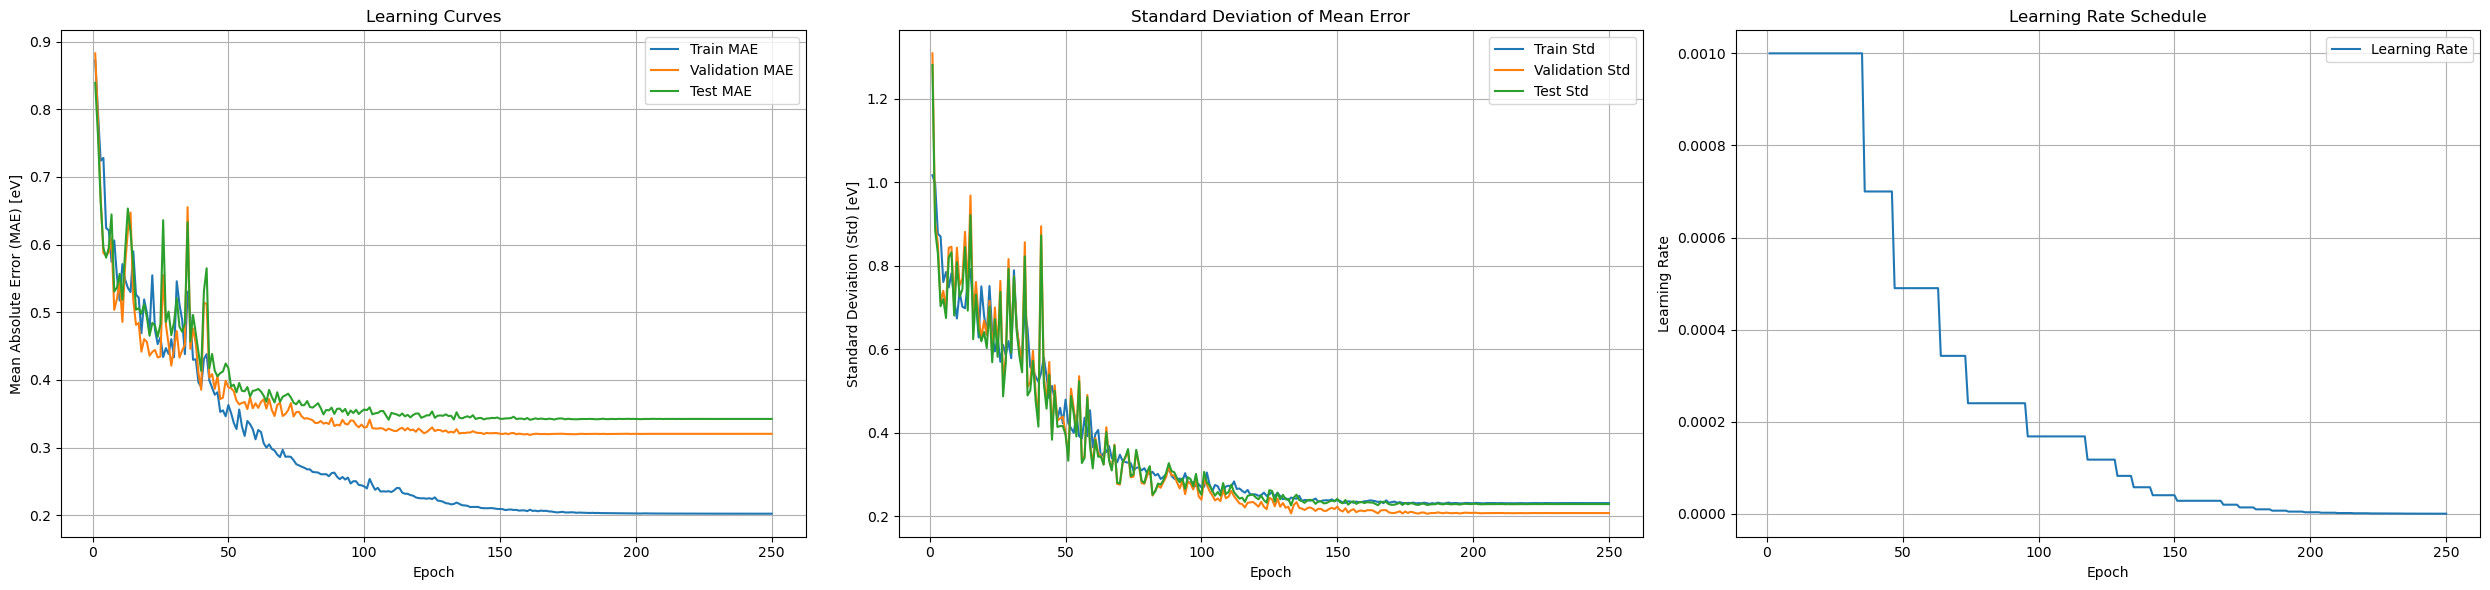

In [2]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))

# Learning Curves (Train, Val, Test MAE)
axs[0].plot(df_training['Epoch'], df_training['Train_MAE_eV'], label='Train MAE')
axs[0].plot(df_training['Epoch'], df_training['Val_MAE_eV'], label='Validation MAE')
axs[0].plot(df_training['Epoch'], df_training['Test_MAE_eV'], label='Test MAE')

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Mean Absolute Error (MAE) [eV]')
axs[0].set_title('Learning Curves')
axs[0].legend()
axs[0].grid(True)

# Standard Deviation of Predictions (Train, Val, Test Std)
axs[1].plot(df_training['Epoch'], df_training['Train_std_eV'], label='Train Std')
axs[1].plot(df_training['Epoch'], df_training['Val_std_eV'], label='Validation Std')
axs[1].plot(df_training['Epoch'], df_training['Test_std_eV'], label='Test Std')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Standard Deviation (Std) [eV]')
axs[1].set_title('Standard Deviation of Mean Error')
axs[1].legend()
axs[1].grid(True)

# Learning Rate Schedule
axs[2].plot(df_training['Epoch'], df_training['Learning_Rate'], label='Learning Rate')

axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')
axs[2].set_title('Learning Rate Schedule')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


##  Evaluation of the test set

/tmp/ipykernel_4030996/2000079371.py:7: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(df_test_set, x='True_eV', y='Prediction_eV', alpha=0.7, hue= "Dissociation", s=100, palette= palette, style = "State", ax=axes[0])


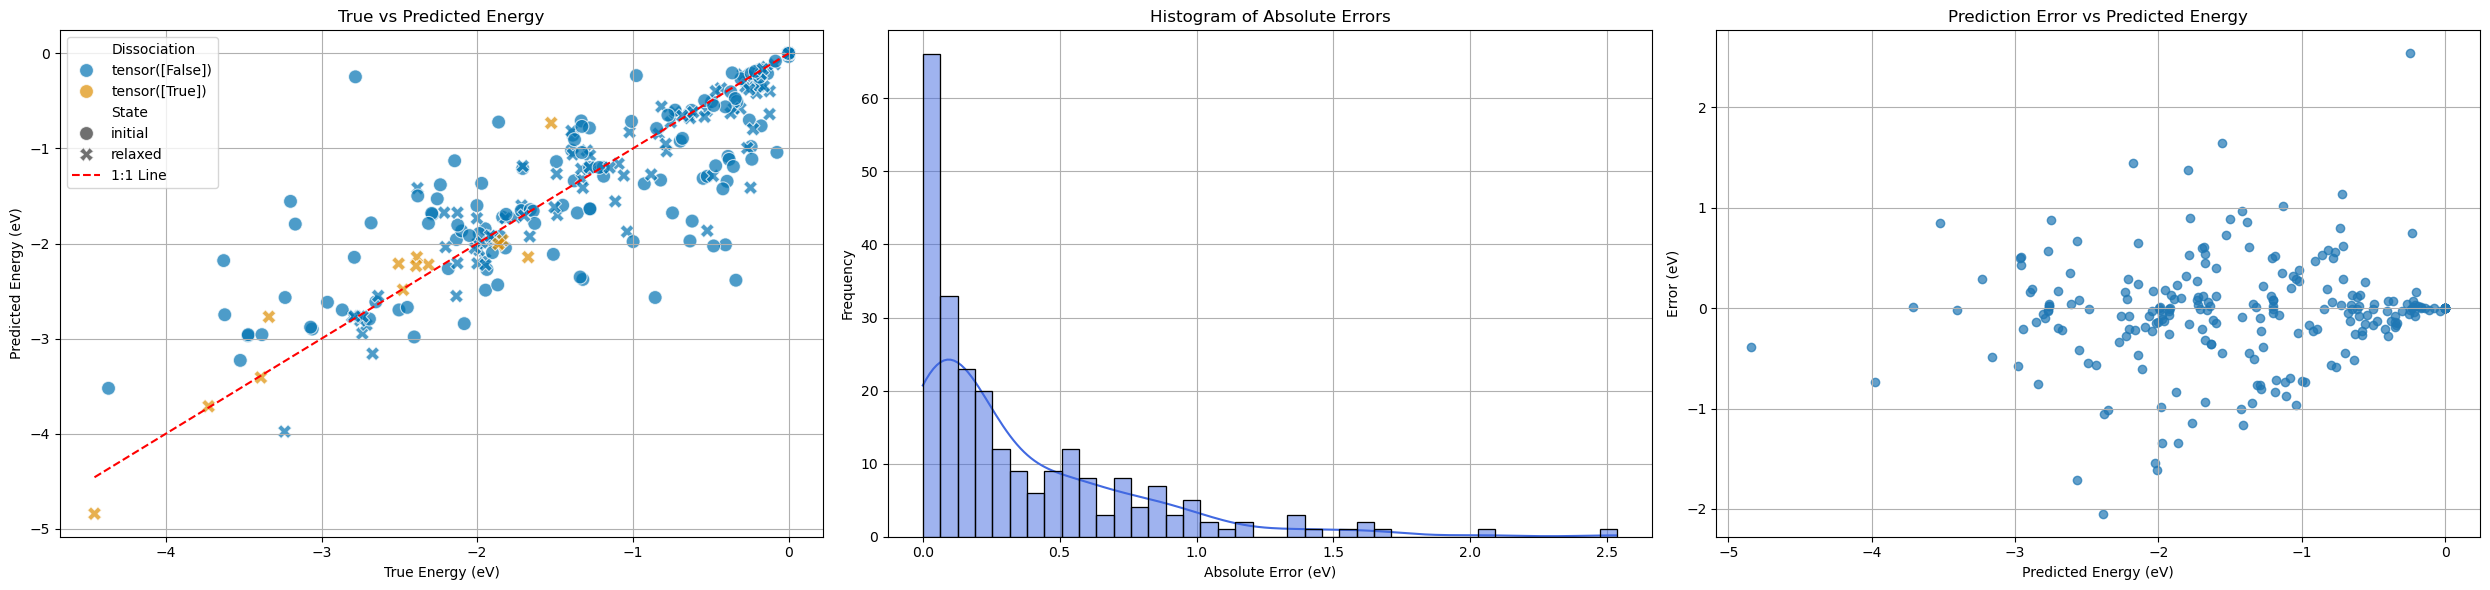

In [3]:
palette = sns.color_palette("colorblind")

fig, axes = plt.subplots(1, 3, figsize=(25, 6))  

# True vs. Predicted Energy Plot
# sns.scatterplot(df_test_set, x='True_eV', y='Prediction_eV', alpha=0.7, hue= "Material", s=100, palette= palette, ax=axes[0])
sns.scatterplot(df_test_set, x='True_eV', y='Prediction_eV', alpha=0.7, hue= "Dissociation", s=100, palette= palette, style = "State", ax=axes[0])
# sns.scatterplot(df_test_set, x='True_eV', y='Prediction_eV', alpha=0.7, hue= "Material", s=100, palette= palette, style = "Dissociation", ax=axes[0])
axes[0].plot([min(df_test_set['True_eV']), max(df_test_set['True_eV'])], 
             [min(df_test_set['True_eV']), max(df_test_set['True_eV'])], 
             'r--', label='1:1 Line')
axes[0].set_xlabel('True Energy (eV)')
axes[0].set_ylabel('Predicted Energy (eV)')
axes[0].set_title('True vs Predicted Energy')
axes[0].legend()
axes[0].grid(True)

# Histogram of Absolute Errors
sns.histplot(df_test_set['Abs_error_eV'], bins=40, kde=True, color='royalblue', ax=axes[1], zorder = 10)
axes[1].set_xlabel('Absolute Error (eV)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Absolute Errors')
axes[1].grid(True)

# Prediction Error vs. Predicted Energy
axes[2].scatter(df_test_set['Prediction_eV'], df_test_set['Error_eV'], alpha=0.7)
axes[2].set_xlabel('Predicted Energy (eV)')
axes[2].set_ylabel('Error (eV)')
axes[2].set_title('Prediction Error vs Predicted Energy')
axes[2].grid(True)

plt.tight_layout()
plt.show()


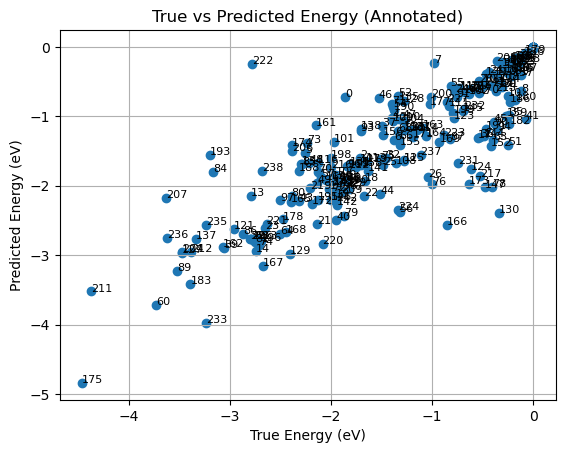

In [4]:
# Identify points of interest (e.g., large negative error)
outliers = (df_test_set['True_eV'] < -0) & (df_test_set['Prediction_eV'] < -0)

# Use the mask to filter the actual rows
outlier_rows = df_test_set[outliers]

fig, ax = plt.subplots()
scatter = ax.scatter(df_test_set["True_eV"], df_test_set["Prediction_eV"])

# Annotate interesting points
for i, row in outlier_rows.iterrows():
    ax.annotate(f"{i}", (row["True_eV"], row["Prediction_eV"]), fontsize=8)

plt.xlabel("True Energy (eV)")
plt.ylabel("Predicted Energy (eV)")
plt.title("True vs Predicted Energy (Annotated)")
plt.grid(True)
plt.show()

In [5]:
entry = df_test_set.iloc[207]
entry

System                CH3Ir40NO81
Material                     IrO2
Surface                     110.0
Molecule Group             amides
Molecule                Formamide
State                     initial
Dissociation      tensor([False])
True_eV                 -3.628155
Prediction_eV           -2.178945
Error_eV                  1.44921
Abs_error_eV              1.44921
Name: 207, dtype: object

## Uncertainty quantification

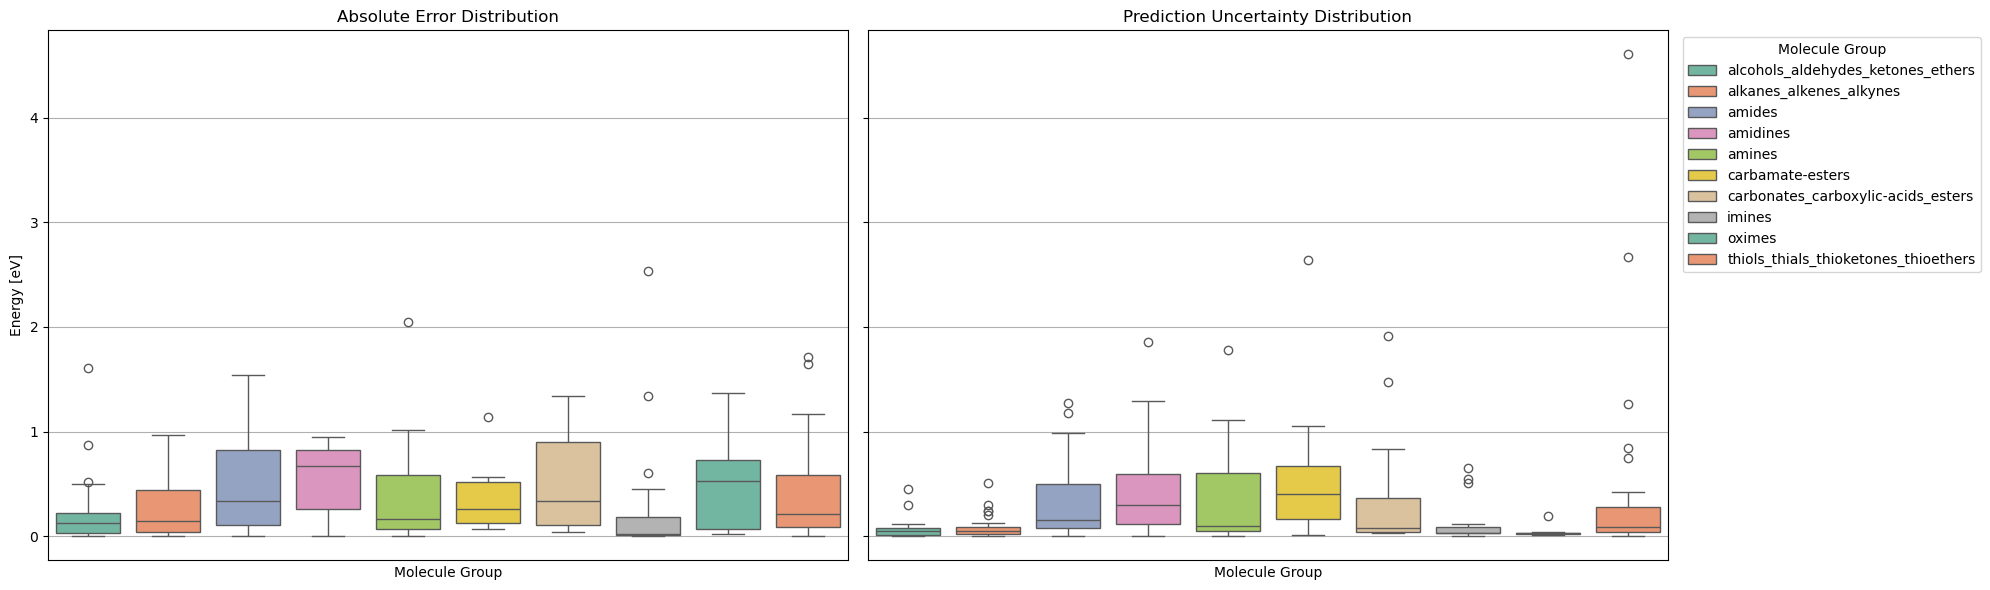

In [6]:
df_uq_sorted = df_uq[df_uq["split"] == "test"].sort_values('molecule_group')

df_uq_sorted['abs_error'] = df_uq_sorted['error'].abs()
df_uq_sorted['uncertainty_width'] = df_uq_sorted['y_std']

# Create subplots with shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# First subplot: Absolute Error
sns.boxplot(data=df_uq_sorted, x='molecule_group', y='abs_error', hue='molecule_group', palette="Set2", legend=False, ax=axes[0])
axes[0].set_xlabel('Molecule Group')
axes[0].set_ylabel('Energy [eV]')
axes[0].set_title('Absolute Error Distribution')
axes[0].set_xticks([])
axes[0].grid(True)

# Second subplot: Uncertainty Width
sns.boxplot(data=df_uq_sorted, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette="Set2", legend=True, ax=axes[1])
axes[1].set_xlabel('Molecule Group')
axes[1].set_ylabel('')  # Shared y-label already on left
axes[1].set_title('Prediction Uncertainty Distribution')
axes[1].set_xticks([])
axes[1].grid(True)
axes[1].legend(title='Molecule Group', bbox_to_anchor=(1.01, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


## Uncertainty Qualification per Surface

In [7]:
df_uq_sorted.groupby('material')['abs_error'].count()

material
IrO2    106
RuO2    123
Name: abs_error, dtype: int64

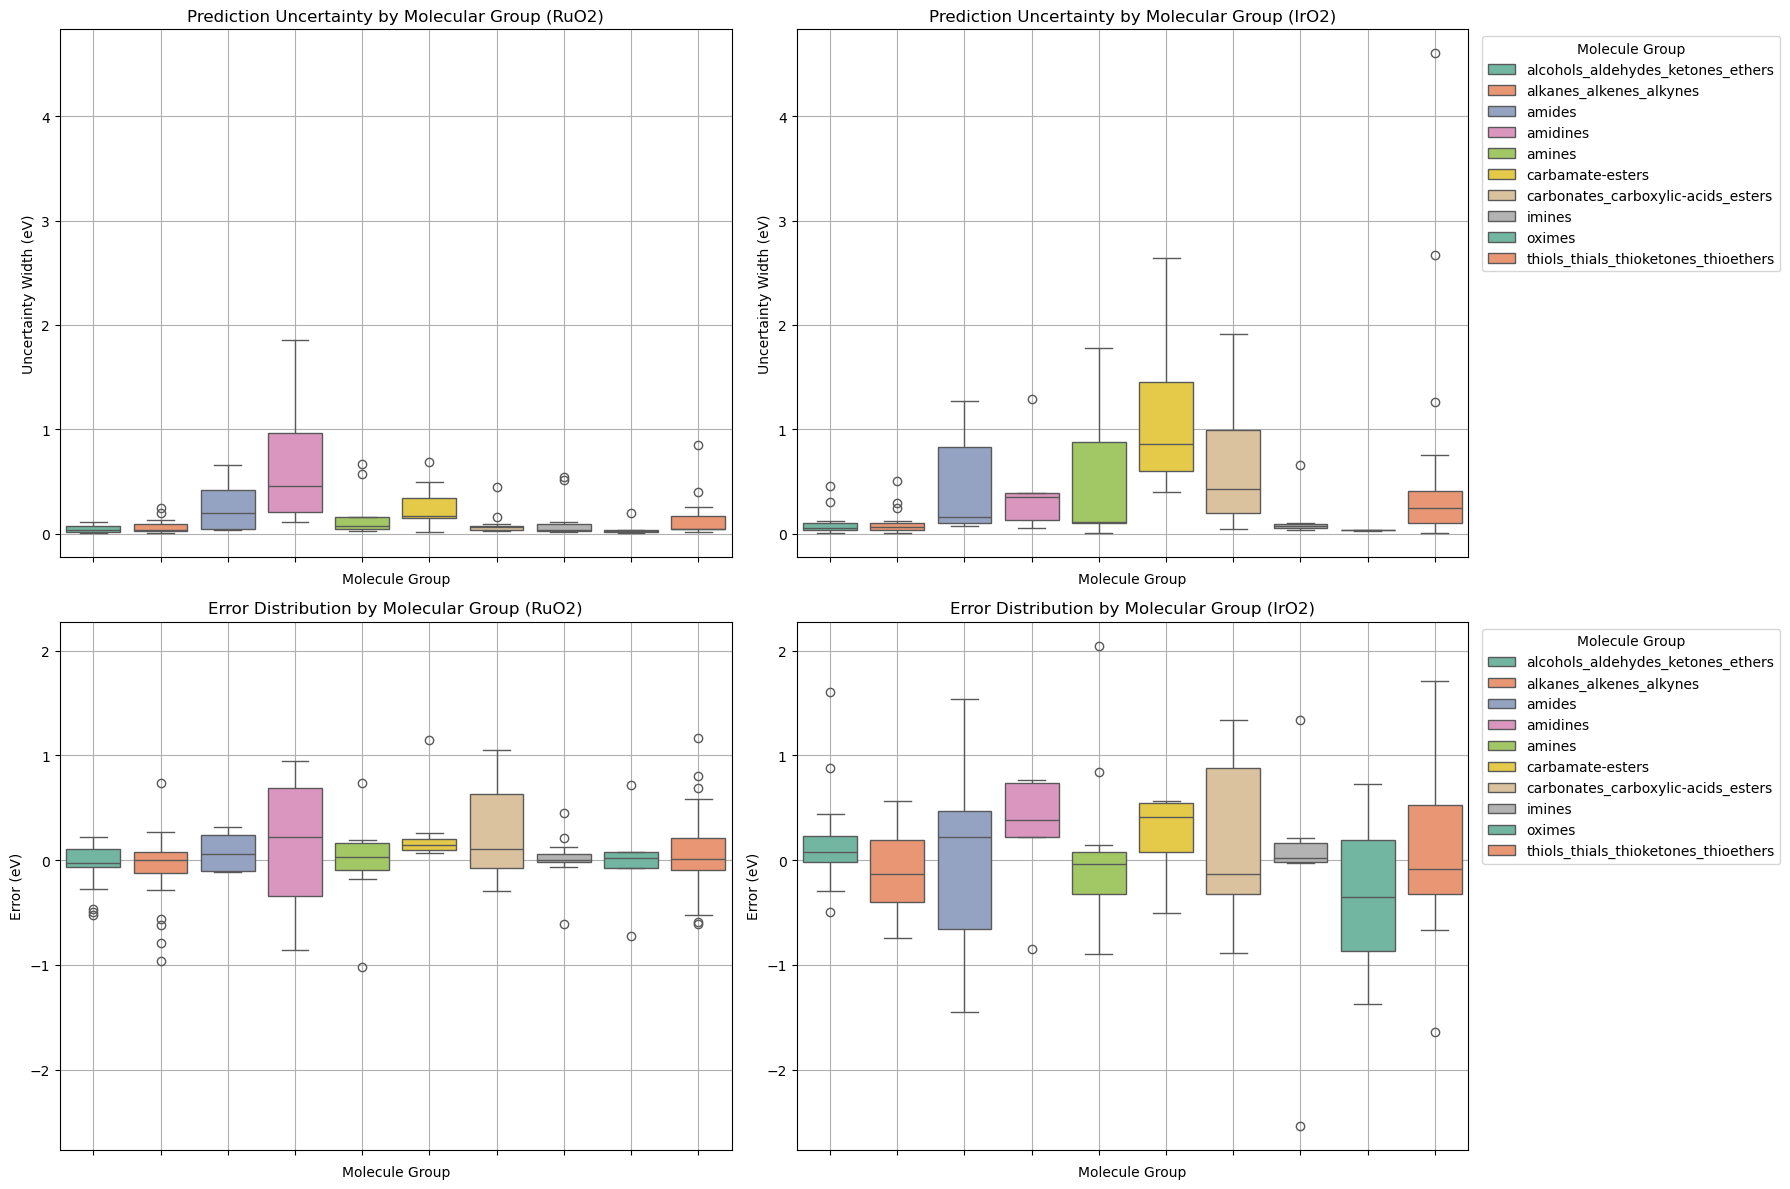

In [8]:
# Filter per material
df_ru = df_uq_sorted[df_uq_sorted['material'] == 'RuO2']
df_ir = df_uq_sorted[df_uq_sorted['material'] == 'IrO2']


# Create figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # 1 row, 2 columns

# RuO2 plot
sns.boxplot(data=df_ru, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette='Set2', legend=False, ax=axes[0,0]
)
axes[0,0].set_title("Prediction Uncertainty by Molecular Group (RuO2)")
axes[0,0].set_xlabel("Molecule Group")
axes[0,0].set_ylabel("Uncertainty Width (eV)")
axes[0,0].set_xticklabels([])
axes[0,0].grid(True)
axes[0,0].sharey(axes[0,1])


# IrO2 plot
sns.boxplot(data=df_ir, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette='Set2', legend=True, ax=axes[0,1])
axes[0,1].set_title("Prediction Uncertainty by Molecular Group (IrO2)")
axes[0,1].set_xlabel("Molecule Group")
axes[0,1].set_ylabel("Uncertainty Width (eV)")
axes[0,1].set_xticklabels([])
axes[0,1].grid(True)
axes[0,1].legend(title='Molecule Group', bbox_to_anchor=(1.01, 1), loc='upper left')

# RuO2 plot
sns.boxplot(data=df_ru, x='molecule_group', y='error', hue='molecule_group', palette='Set2', legend=False, ax=axes[1,0]
)
axes[1,0].set_title("Error Distribution by Molecular Group (RuO2)")
axes[1,0].set_xlabel("Molecule Group")
axes[1,0].set_ylabel("Error (eV)")
axes[1,0].set_xticklabels([])
axes[1,0].grid(True)
axes[1,0].sharey(axes[1,1])


# IrO2 plot
sns.boxplot(data=df_ir, x='molecule_group', y='error', hue='molecule_group', palette='Set2', legend=True, ax=axes[1,1])
axes[1,1].set_title("Error Distribution by Molecular Group (IrO2)")
axes[1,1].set_xlabel("Molecule Group")
axes[1,1].set_ylabel("Error (eV)")
axes[1,1].set_xticklabels([])
axes[1,1].grid(True)
axes[1,1].legend(title='Molecule Group', bbox_to_anchor=(1.01, 1), loc='upper left')



plt.tight_layout()
plt.show()


In [9]:
df_uq.sort_values(["y_true"], ascending=True).head(15)

,formula,material,surface,molecule_group,molecule,state,y_true,y_mean,y_std,y_min,y_max,in_interval,error,split,dissociation,norm_res
456,C2H6Ir40N2O80,IrO2,110.0,amidines,Acetimidamide,initial,-4.457949,-4.329080,0.153316,-4.629580,-4.028580,True,-0.128869,train,tensor([False]),-0.840544
1148,C2H6Ir40N2O80,IrO2,110.0,amidines,Acetimidamide,relaxed,-4.457949,-4.841065,0.051340,-4.941692,-4.740438,False,0.383116,test,tensor([True]),7.462305
436,CH4Ir40N2O80,IrO2,110.0,amidines,Formimidamide,initial,-4.369982,-3.685900,0.719172,-5.095476,-2.276323,True,-0.684082,train,tensor([False]),-0.951208
1184,CH4Ir40N2O80,IrO2,110.0,amidines,Formimidamide,initial,-4.367753,-3.521999,0.354565,-4.216946,-2.827052,False,-0.845754,test,tensor([False]),-2.385330
237,CH4Ir40N2O80,IrO2,110.0,amidines,Formimidamide,relaxed,-4.367753,-4.450125,0.089186,-4.624929,-4.275321,True,0.082372,train,tensor([True]),0.923601
323,C2H5Ir40NO81,IrO2,110.0,amides,Acetamide,initial,-3.725091,-2.125956,1.315313,-4.703969,0.452058,True,-1.599135,train,tensor([False]),-1.215783
1033,C2H5Ir40NO81,IrO2,110.0,amides,Acetamide,relaxed,-3.725091,-3.711427,0.071656,-3.851872,-3.570981,True,-0.013664,test,tensor([True]),-0.190690
349,CH3Ir40NO81,IrO2,110.0,amides,Formamide,initial,-3.628545,-2.385997,1.312449,-4.958396,0.186403,True,-1.242549,train,tensor([False]),-0.946741
1180,CH3Ir40NO81,IrO2,110.0,amides,Formamide,initial,-3.628156,-2.178945,0.341483,-2.848252,-1.509638,False,-1.449210,test,tensor([False]),-4.243872
786,CH3Ir40NO81,IrO2,110.0,amides,Formamide,initial,-3.627820,-0.795420,0.093169,-0.978032,-0.612809,False,-2.832399,val,tensor([False]),-30.400663


In [10]:
df_uq_sorted.sort_values(["y_std"], ascending=False).head(20)

,formula,material,surface,molecule_group,molecule,state,y_true,y_mean,y_std,y_min,y_max,in_interval,error,split,dissociation,norm_res,abs_error,uncertainty_width
1166,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethiol,initial,-3.199007,-1.555887,4.603965,-10.579658,7.467885,True,-1.643121,test,tensor([False]),-0.356893,1.643121,4.603965
1204,C3H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thione,initial,-0.745690,-1.677679,2.671885,-6.914573,3.559216,True,0.931989,test,tensor([False]),0.348813,0.931989,2.671885
1100,CH3Ir40NO82,IrO2,110.0,carbamate-esters,Carbamic-acid,initial,-3.471884,-2.969234,2.640138,-8.143904,2.205436,True,-0.502650,test,tensor([False]),-0.190388,0.502650,2.640138
996,CH2Ir40O83,IrO2,110.0,carbonates_carboxylic-acids_esters,Carbonic-acid,initial,-2.650964,-2.612884,1.912699,-6.361774,1.136007,True,-0.038080,test,tensor([False]),-0.019909,0.038080,1.912699
1036,CH4N2O80Ru40,RuO2,110.0,amidines,Formimidamide,initial,-0.395336,-1.344672,1.857949,-4.986252,2.296908,True,0.949336,test,tensor([False]),0.510959,0.949336,1.857949
1103,C2H7Ir40NO80,IrO2,110.0,amines,Ethanamine,initial,-0.338456,-2.385340,1.783258,-5.880525,1.109846,True,2.046884,test,tensor([False]),1.147834,2.046884,1.783258
1067,C2H4Ir40O82,IrO2,110.0,carbonates_carboxylic-acids_esters,Acetic-acid,initial,-0.354621,-1.189552,1.479124,-4.088635,1.709531,True,0.834931,test,tensor([False]),0.564477,0.834931,1.479124
990,C2H6Ir40N2O80,IrO2,110.0,amidines,Acetimidamide,initial,-0.549138,-1.314116,1.290935,-3.844348,1.216116,True,0.764978,test,tensor([False]),0.592577,0.764978,1.290935
1120,CH3Ir40NO81,IrO2,110.0,amides,Formamide,initial,-0.481715,-2.024972,1.272074,-4.518238,0.468294,True,1.543257,test,tensor([False]),1.213182,1.543257,1.272074
1125,C2H4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethial,initial,-0.421980,-1.424329,1.260184,-3.894289,1.045632,True,1.002348,test,tensor([False]),0.795399,1.002348,1.260184


In [11]:
df_uq.sort_values(["error"], ascending=False).head(15)

,formula,material,surface,molecule_group,molecule,state,y_true,y_mean,y_std,y_min,y_max,in_interval,error,split,dissociation,norm_res
438,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,initial,-0.211618,-2.316360,1.970501,-6.178542,1.545823,True,2.104742,train,tensor([False]),1.068125
1103,C2H7Ir40NO80,IrO2,110.0,amines,Ethanamine,initial,-0.338456,-2.385340,1.783258,-5.880525,1.109846,True,2.046884,test,tensor([False]),1.147834
778,C3H9Ir40NO80,IrO2,110.0,amines,Propan-2-amine,initial,-0.474136,-2.438041,0.951140,-4.302276,-0.573806,False,1.963904,val,tensor([False]),2.064789
789,C2H6Ir40N2O80,IrO2,110.0,amidines,Acetimidamide,initial,-0.060982,-1.993571,2.608698,-7.106618,3.119477,True,1.932588,val,tensor([False]),0.740825
1139,CH2Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethial,initial,-0.857223,-2.567262,0.066272,-2.697155,-2.437369,False,1.710039,test,tensor([False]),25.803340
919,CH2Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethial,relaxed,-0.857223,-2.567262,0.066272,-2.697155,-2.437369,False,1.710039,val,tensor([False]),25.803340
1051,C3H6Ir40O81,IrO2,110.0,alcohols_aldehydes_ketones_ethers,Propan-2-one,initial,-0.405574,-2.013293,0.452810,-2.900800,-1.125786,False,1.607719,test,tensor([False]),3.550540
744,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,relaxed,-0.321731,-1.920745,1.288924,-4.447035,0.605546,True,1.599014,val,tensor([False]),1.240581
74,C2H6Ir40N2O80,IrO2,110.0,amidines,Acetimidamide,initial,-0.444483,-1.989961,2.200496,-6.302934,2.323012,True,1.545477,train,tensor([False]),0.702331
153,CH3Ir40NO81,IrO2,110.0,amides,Formamide,relaxed,-0.481715,-2.024972,1.272074,-4.518238,0.468294,True,1.543257,train,tensor([False]),1.213182


In [12]:
outliers = df_uq[df_uq["formula"] == "CH4Ir40O80S"]
outliers

,formula,material,surface,molecule_group,molecule,state,y_true,y_mean,y_std,y_min,y_max,in_interval,error,split,dissociation,norm_res
139,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,initial,-3.142078,-3.080455,0.323413,-3.714345,-2.446566,True,-0.061623,train,tensor([False]),-0.190539
180,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,initial,-2.470673,-2.810513,0.315454,-3.428803,-2.192223,True,0.339840,train,tensor([False]),1.077305
205,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,relaxed,-3.142078,-3.028671,0.082086,-3.189560,-2.867782,True,-0.113407,train,tensor([True]),-1.381556
497,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,initial,-3.143192,-2.810513,0.315454,-3.428803,-2.192223,True,-0.332679,train,tensor([False]),-1.054603
587,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,relaxed,-2.470673,-2.810513,0.315454,-3.428803,-2.192223,True,0.339840,train,tensor([False]),1.077305
624,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,relaxed,-3.070039,-3.024514,0.078766,-3.178895,-2.870132,True,-0.045525,train,tensor([True]),-0.577978
731,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,relaxed,-2.486884,-2.810513,0.315454,-3.428803,-2.192223,True,0.323629,val,tensor([False]),1.025914
744,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,relaxed,-0.321731,-1.920745,1.288924,-4.447035,0.605546,True,1.599014,val,tensor([False]),1.240581
870,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,initial,-0.321731,-1.200365,1.271620,-3.692740,1.292010,True,0.878634,val,tensor([False]),0.690956
874,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,initial,-2.486884,-2.719210,0.270837,-3.250051,-2.188369,True,0.232326,val,tensor([False]),0.857807


In [13]:
df_test_set[((df_test_set["Molecule Group"] == "thiols_thials_thioketones_thioethers") & (df_test_set["Material"] == "IrO2"))].sort_values("Molecule")

,System,Material,Surface,Molecule Group,Molecule,State,Dissociation,True_eV,Prediction_eV,Error_eV,Abs_error_eV
64,C2H4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethial,initial,tensor([False]),-2.502474,-2.698161,-0.195687,0.195687
86,C2H4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethial,initial,tensor([False]),-2.866476,-2.698161,0.168315,0.168315
220,C2H4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethial,initial,tensor([False]),-2.083250,-2.842312,-0.759062,0.759062
152,C2H4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethial,initial,tensor([False]),-0.421980,-1.424329,-1.002349,1.002349
89,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethiol,initial,tensor([False]),-3.521611,-3.228472,0.293139,0.293139
129,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethiol,initial,tensor([False]),-2.404696,-2.982221,-0.577526,0.577526
193,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethiol,initial,tensor([False]),-3.199007,-1.555887,1.643121,1.643121
183,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethiol,relaxed,tensor([True]),-3.389266,-3.408397,-0.019131,0.019131
166,CH2Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethial,initial,tensor([False]),-0.857223,-2.567262,-1.710039,1.710039
221,CH2Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethial,relaxed,tensor([False]),-2.636059,-2.551321,0.084737,0.084737
